<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NEURO-421)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Functional connectivity, graphs and connectomes</font></h1>


Run the next cell to make sure that you have all required Python libraries installed. Once you have done that, run the cell below it to import all the libraries you will be using, declare some useful functions and to set up your environment.  

In [1]:
!pip install networkx
!pip install pygsp 

In [10]:
#This section imports the needed libraries and defines the used functions:
import numpy as np, os
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from construct_knn_graph import construct_knn_graph
import pygsp
from pygsp import graphs
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.cluster import KMeans
import networkx as nx
from sklearn.svm import LinearSVC
from nilearn.datasets import fetch_atlas_aal


plt.rcParams["figure.figsize"] = (12,8)

/Users/iricchi/opt/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# 1. Functional connectivity

As you have seen in class, one of the most intuitive approach to estimate functional connectivity is performing simple Pearson correlations of a seed region with respect to all the other regions. This information will give us information on how the activity of the seed regions correlate with the rest of the brain.

In [3]:
# Load brain region names
CBmat = scipy.io.loadmat("./FC_graphs_data/CB")
CB = CBmat['CB'].tolist()
CB = np.squeeze(np.asarray(CB).tolist())
# Load test adjacency matrix
Testmat = scipy.io.loadmat("./FC_graphs_data/Test")
Test = Testmat['Test'].tolist()
Test = np.squeeze(np.asarray(Test).tolist())
# Load all time courses per region per subject (we have 54 subjects)
TCSmat=scipy.io.loadmat("./FC_graphs_data/TCS")
TCS=TCSmat['TCS'].tolist()
TCS = np.squeeze(np.asarray(TCS).tolist())

In [4]:
TCS.shape

(54, 90, 1190)

Let's start with only one subject for simplicity (the first one).

In [5]:
sub1 = TCS[0, :,:]  # we will have the 90 brain regions activity over time 

Text(0, 0.5, 'time (TR)')

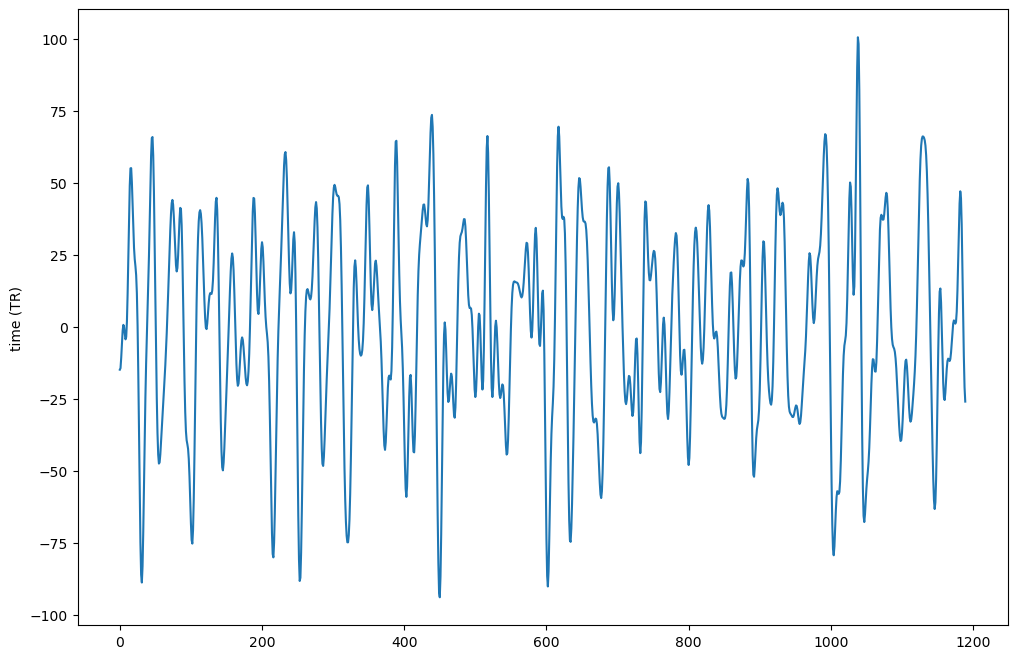

In [6]:
# Select a region to be the seed 
seed = 10 

# plot the time course of the seed
### BEGIN SOLUTION
plt.plot(sub1[seed,:])
plt.ylabel("time (TR)")
### END SOLUTION

In [17]:
## Take from the AAL atlas the labels of each brain region
brain_regions_labels = fetch_atlas_aal()['labels'][:90]

# Check your seed what region is it?

### BEGIN SOLUTION
brain_regions_labels[seed]
### END SOLUTION

'Frontal_Inf_Oper_L'

Text(0.5, 0, 'Brain regions')

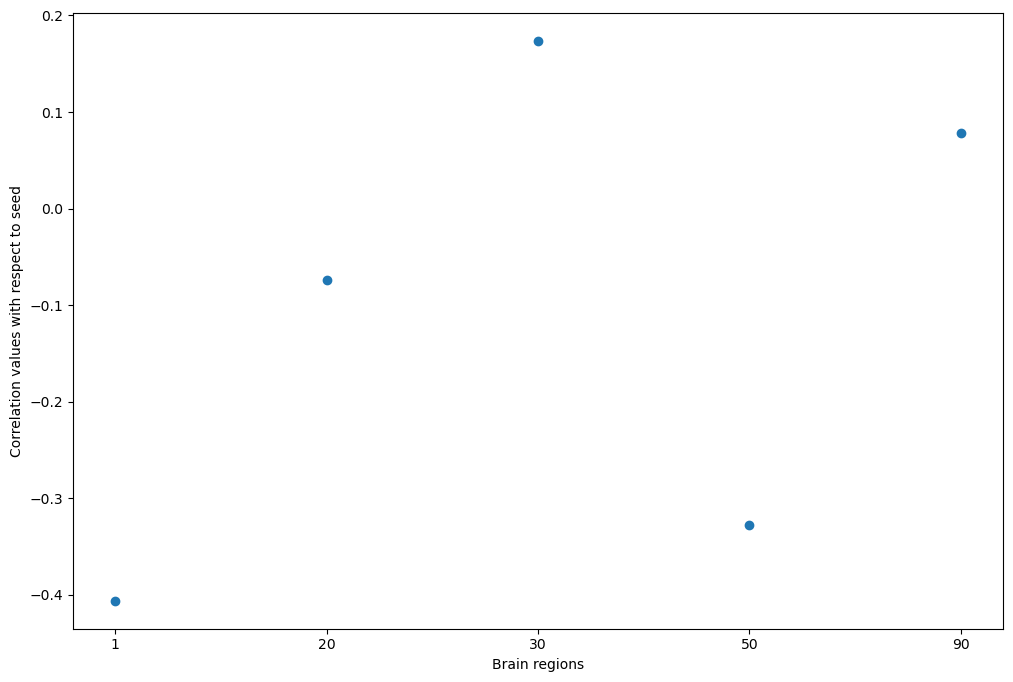

In [33]:
# Select some brain regions that you are interested in seeing and consider how their function correlate with your seed

# plot the results of the correlations and interpret your results

### BEGIN SOLUTION
regions = [1,20,30,50,90]
corrs = []
for reg in regions:
    corrs.append(np.corrcoef(sub1[:,seed],sub1[:,reg])[0,1])
    
plt.figure()
plt.scatter(np.arange(len(regions)), corrs)
plt.xticks(np.arange(len(regions)),regions)
plt.ylabel("Correlation values with respect to seed")
plt.xlabel("Brain regions")
### END SOLUTION`


# Interpret the results

Now, try to change the seed and re-run the cell. 

#### Reflection point: 

Interpret the results: ...? 

Now, let's compute a region-based approach: we will compute the correlation across all region to compute a full functional connectivity matrix. This approach gives us more info of the possible functional network that are correlating across the brain. 

In [10]:
#View_A() is a useful function for plotting the functional connectivity matrix (FC)
def View_A(X,labels, labels_on=True,size=14,grid=True):
    N=X.shape[0]
    plt.rcParams["figure.figsize"] = (size,size)
    plt.imshow(X, cmap="jet")
    plt.xlim([N,0])
    plt.ylim([0,N])
    plt.colorbar()
    if labels_on==False:
        labels=['']*X.shape[0]
    locs, labs = plt.xticks()           # Get locations and labels
    plt.xticks(np.arange(0,N), labels, rotation=90, fontsize=7)
    plt.yticks(np.arange(0,N), labels, fontsize=7)
    if grid==True:
        plt.grid(color='k', linestyle='-', linewidth=1.5)
    plt.show()

We start by filling in the `ComputeAdjacency()` function. This function takes the time courses of one subject as an argument, and returns a $90\times 90$ connectivity matrix reflecting the synchrony between time courses as computed by Pearson’s correlation coefficient (as implemented in the function [`numpy.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)). 

The function takes as a parameter:
 * `X` (NumPy Array): the time courses per region for ONE subject, i.e. a matrix of size 90x1190,

And returns as parameter:
 * `output` (NumPy Array): connectivity matrix of size $90\times 90$, where the entry $(i,j)$ corresponds to the correlation coefficient between $i_{th}$ and $j_{th}$ time course (rows of `X`). Diagonal values of the matrix should also be set to zero. 

<!---
<div alert = 'alert-alert info'>

**HINT**: Two functions that you might find useful are [`numpy.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) and [`numpy.diag`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)
<\div>--->

In [11]:
# Implement the ComputeAdjacency() function using the description given above. 
# Note- Don't forget to set the diagonal values of the matrix to zero.

# def ComputeAdjacency(X): 
#     return ............

### BEGIN SOLUTION
def ComputeAdjacency(X):    
    return np.corrcoef(X)-np.diag(np.diag(np.corrcoef(X)))
### END SOLUTION


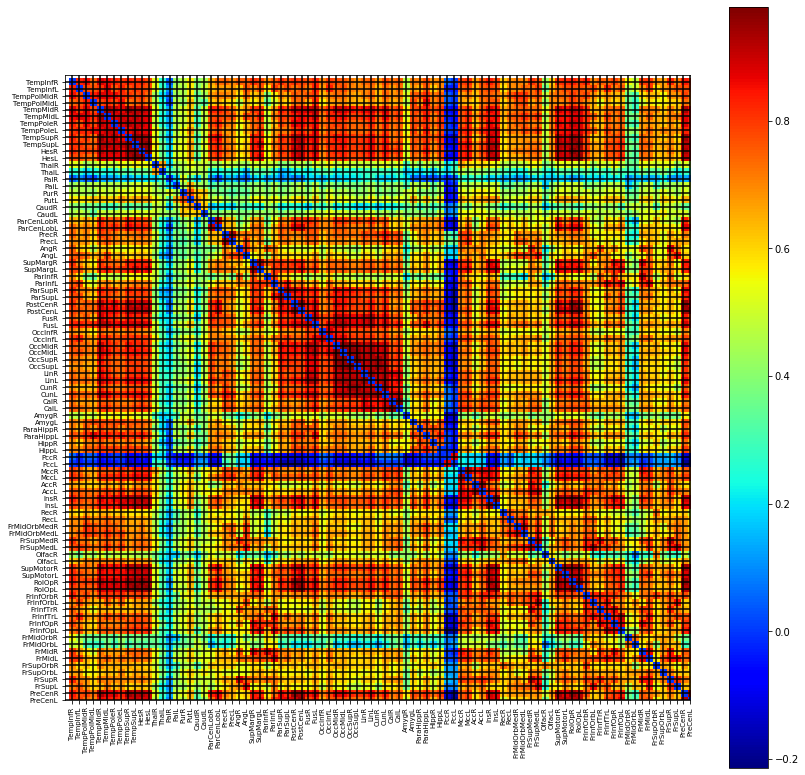

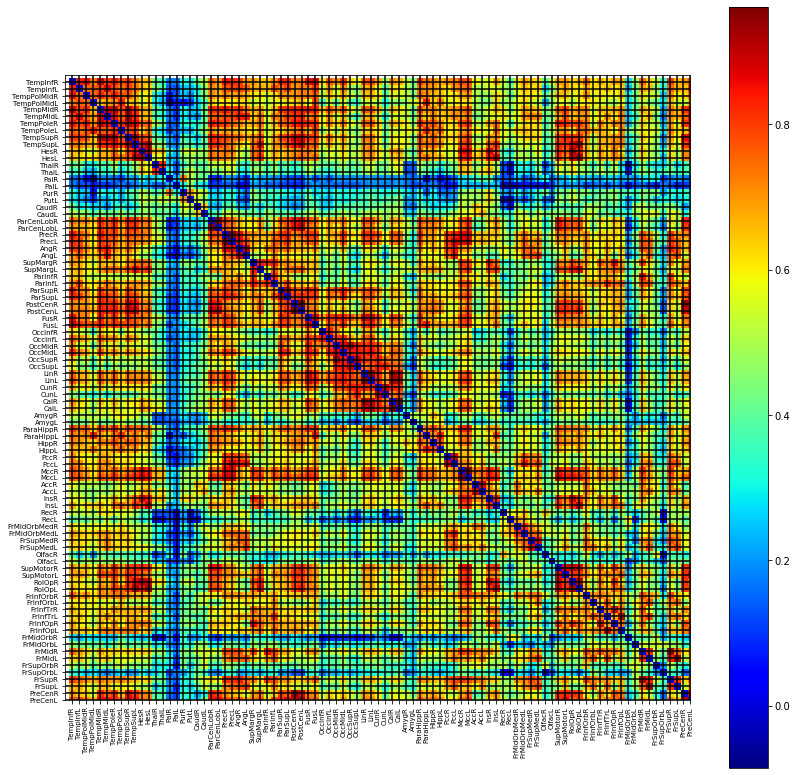

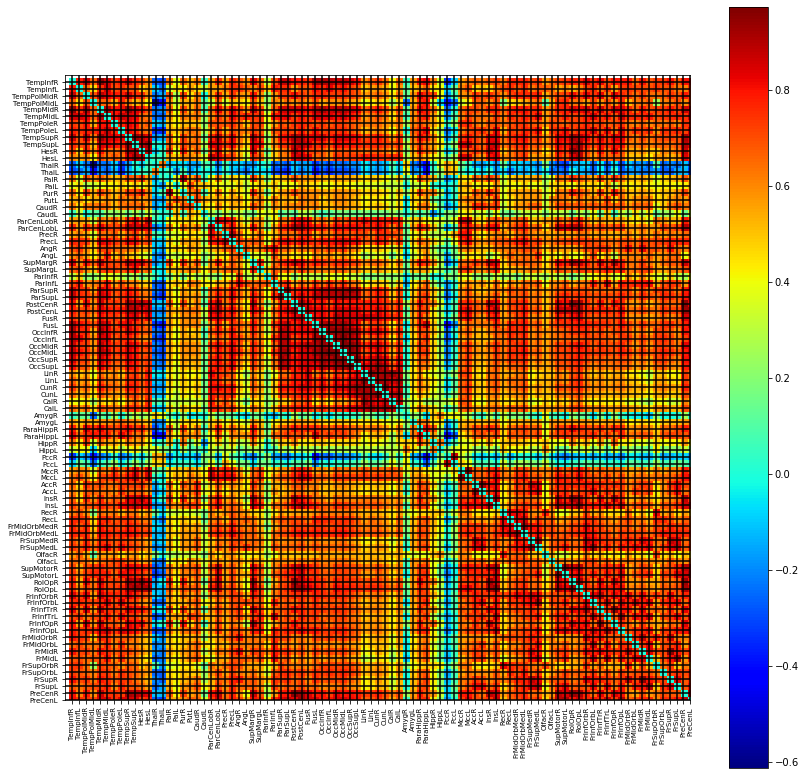

In [42]:
#This section computes and plots the adjacency matrices for three subjects
A_sub1 = ComputeAdjacency(TCS[0,:,:])
A_sub2 = ComputeAdjacency(TCS[1,:,:])
A_sub8 = ComputeAdjacency(TCS[7,:,:])
View_A(A_sub1,CB)
View_A(A_sub2,CB)
View_A(A_sub8,CB)

#### Reflection point:

Take a close look at the adjacency matrix plotted above (if you want to see matrices for other subjects, you can change the index of the first dimension of the variable TCS in the lab).

What can we say about recurring patterns of functional connectivity?
Look in particular at occipital regions (Cal, Cun, Lin, OccSup, OccInf) across the 3 subjects.

Before computing graph metrics, connectivity matrices need to be made binary. To do so, you will have to fill in the function `BinarizeAdjacency()`, which takes a non-binary $90\times 90$ connectivity matrix and a density fraction value (in the range $[0,1]$) as inputs, and returns a binary connectivity matrix. For example, a $0.5$ density value means that only the $50\%$ strongest connections must be retained in the output matrix. We have to be careful about the fact that we want to only consider the upper diagonal elements of the matrix (excluding diagonal elements themselves) for the calculations. 

Complete the code of the function `BinarizedAdjacency`. The function takes as parameters:
 * `A` (2D NumPyArray): non-binary adjacency matrix A, and 
 * `rho` (scalar): the edge density
 
It returns `A2`, a connectivity matrix of the same size as `A`, where $\rho*100\%$ of the coefficients have been binarized to 1, and the rest to 0.

<div class = 'alert alert-info'>

**Note:** the function already includes certain lines of code at the beginning and the end of the body, respectively converting a matrix's upper entries into a vector, and converting a vector into a symmetric matrix.

**Hint:** You can use the function [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) to sort the indices (pay attention to the default sorting type). 
</div>

In [14]:
def BinarizeAdjacency(A,rho):
    #Do not change the following three lines for extracting off-diagonal entries
    N = A.shape[0] #find the size of the matrix
    # Find the indices of the upper triangle
    ind = np.triu_indices(N, k=1)
    # Vectorize the element (strictly) above the main diagonal of the adjacency
    vec = A[ind] 
    
    ## HINTS: 
    # Sort and flip (sorted returns from small to big) -- look at argsort and flipud from numpy 
    # indmax = ...
    
    # Get the index of the maximum argument that we want to keep (use rho as input) -- compute a sort of percentage to keep
    # perc_keep = ...
    
    # Declare output vector vec2
    vec2 = np.zeros(vec.shape)
    
    # Use indexing with indmax and perc_keep to indicete the indices to set to 1 and 0. 
    
    
    ### BEGIN SOLUTION
    # Sort and flip (sorted returns from small to big)
    indmax = np.flipud(np.argsort(vec))
    # Get the index of the maximum argument that we want to keep
    perc_keep = int(np.round(rho*len(vec)))
    # Declare output vector
    vec2 = np.zeros(vec.shape)
    # Use indexing with indmax to indicete the indices to set to 1 and 0. 
    vec2[indmax[0:perc_keep,]] = 1
    vec2[indmax[(perc_keep+1):],] = 0
    ### END SOLUTION

    # Binarize the vector vec, and keep the result in the variable vec2
    
    # DO NOT CHANGE the following lines for converting a vector of off-diagonal entries into a matrix
    # Declare A2
    A2 = np.zeros((N,N))
    # Set upper triangle to the data of vec2
    A2[ind] = vec2
    # Add it to its transpose, to fill the lower triangle while
    A2=A2+A2.T
    # Make sure that the diagonal is filled with 0s
    A2 = A2 - np.diag(np.diag(A2))
    
    return A2

Test your implementation on the adjacency matrix from `A_sub1` declared above, using the `View_A()` function for visualization:

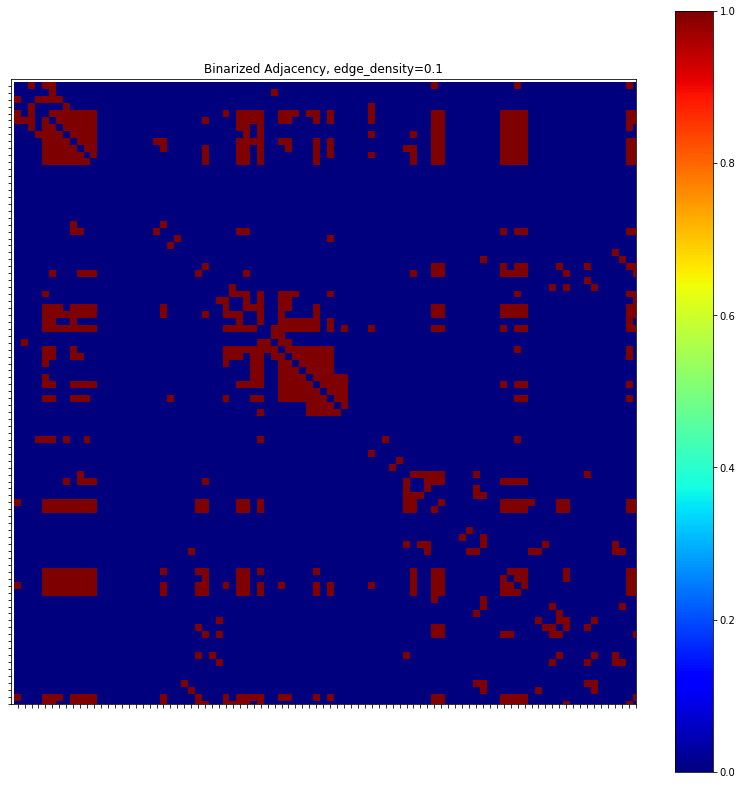

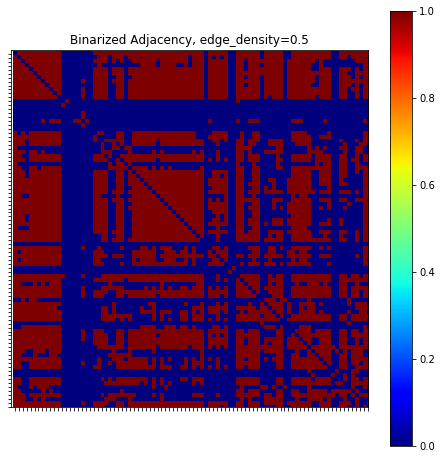

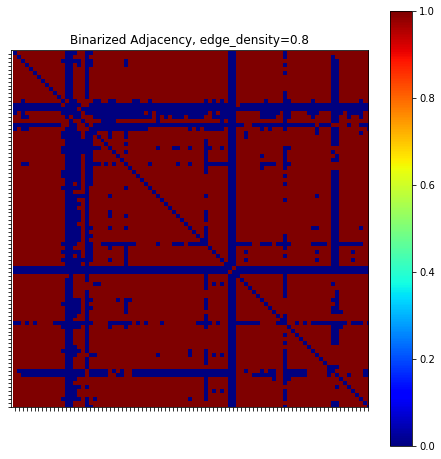

In [15]:
# First we calculate a few examples
Bin10 = BinarizeAdjacency(A_sub1,0.1)
Bin50 = BinarizeAdjacency(A_sub1,0.5)
Bin80 = BinarizeAdjacency(A_sub1,0.8)

# Plot 

#(1)Binarized Adjacency, edge_density=0.1,
#(2)Binarized Adjacency, edge_density=0.5, and
#(3)Binarized Adjacency, edge_density=0.8 
#using the View_A() function defined previously

#Ex- 
#plt.title("Test Adjacency")
#View_A(...,...,size=8,labels_on=False,grid=False)

### BEGIN SOLUTION

plt.title("Binarized Adjacency, edge_density=0.1")
View_A(Bin10,CB,size=8,labels_on=False,grid=False)

plt.title("Binarized Adjacency, edge_density=0.5")
View_A(Bin50,CB,size=8,labels_on=False,grid=False)

plt.title("Binarized Adjacency, edge_density=0.8")
View_A(Bin80,CB,size=8,labels_on=False,grid=False)
### END SOLUTION

# 2. Graph Metrics Evaluation

Now that we have preprocessed and binarized the *Adjacency Matrix*, we need to evaluate it. The metric that we will mainly consider is the nodal clustering coefficient. Look back at your course notes if needed to understand the mathematical definition, the value boundaries and the physiological interpretation of this brain connectivity measure.

For all subjects, we will compute the nodal clustering coefficient at different edge densities (from 0.05 to 0.95, by increments of 0.1). We use the function `ComputeC` to do so, defined at the beginning of the notebook. This function takes a binary adjacency matrix of size $N\times N$ as input and returns a $N$-element nodal clustering coefficient vector. It clusters using the implementation by *NetworkX* in `nx.algorithms.cluster.clustering`. Look at the [documentation](https://networkx.org/documentation/networkx-2.4/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html) for further details on this function.

Run the next cell to calculate the nodal clustering coefficient per node per adjacency matrix for every subject.

In [16]:
# ComputeC takes a binary adjacency matrix of size NxN as input and returns a N-element nodal clustering coefficient vector
# you can use nx.algorithms.cluster.clustering 
# HINTs:
# 1) use the function (nx.convert_matrix.from_numpy_matrix to convert the adjacency matrix
# 2) BE CAREFUL: nx.convert_matrix.from_numpy_matrix needs the matrix to be INT type (convert the adjacency matrix to integers)

def ComputeC(adj1):
    
    ### BEGIN SOLUTION
    ccoefs = nx.algorithms.cluster.clustering(nx.convert_matrix.from_numpy_matrix(adj1.astype(int)))
    ### END SOLUTION
    
    # ccoefs = ...
    
    return np.asarray(list(ccoefs.values()))




In [25]:
rho = np.zeros((10,1))
c = np.zeros((54,10,90))
for sub in range(0,54):
    for rho_ind in range(0,10):
        rho[rho_ind,0] = 0.1 * rho_ind + 0.05
        adj = BinarizeAdjacency(np.squeeze(ComputeAdjacency(TCS[sub,:,:])),rho[rho_ind,0])
        c[sub, rho_ind, :] = ComputeC(adj)
rho_vec = rho

Observe the outcome by plotting all the 90 nodal traces as a function of edge density for a few subjects. You can change the subjects by change the three numbers in the first for loop. Each line in the following plots corresponds to one of the 90 nodes in the graph.

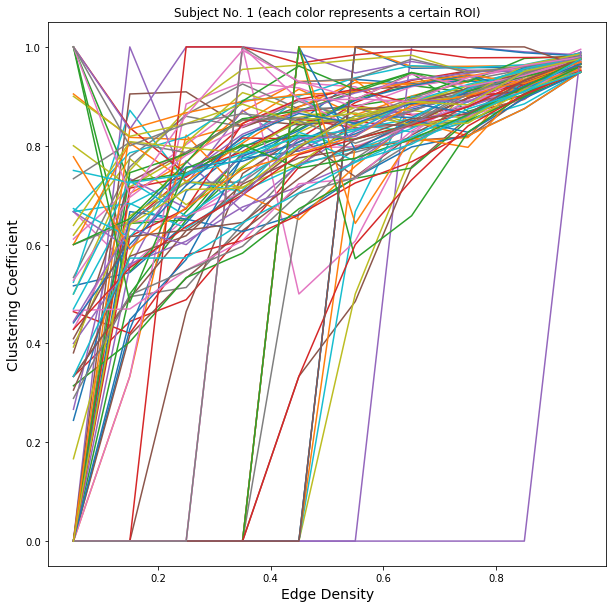

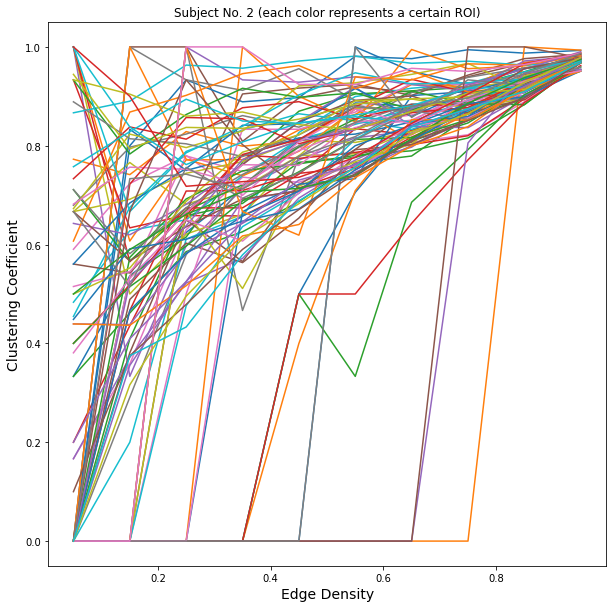

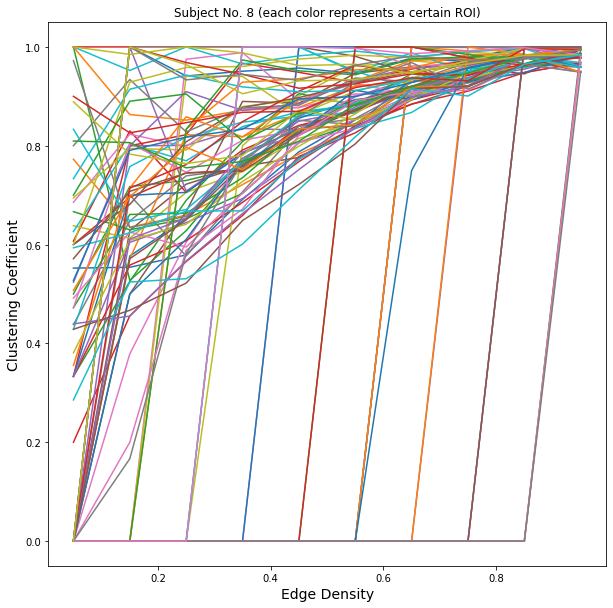

In [26]:
# Change the iterable to plot different subjects
for sub in [1, 2, 8]:
    plt.rcParams["figure.figsize"] = (10,10)
    # Iterate through each node and add to graph
    for node in range(0,90):
        plt.plot(rho, c[sub,:,node], label=str(node))
    # Format graph
    plt.xlabel("Edge Density",fontsize=14)
    plt.ylabel("Clustering Coefficient",fontsize=14)
    plt.title("Subject No. " + str(sub) + ' (each color represents a certain ROI)')
    plt.show()

#### Reflection point:

The fact that for small edge densities, the ratio of the real (measured) to random graph is much larger than 1 is enough to claim that the brain is structured: Information flows more efficiently than in a random network. Thus, the brain is a small world network. But remember to consider also the **path length**!

We will now try to compare the obtained results to the ones of a random graph
model with similar edge density. Using the function [`networkx.erdos_renyi_graph`](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html), which
takes as input parameters:
 * `n` (int): the number of nodes, and
 * `p` (float): the probability of connection, i.e. edge density.

It returns a graph structure.

Complete the next cell to generate a random graph of 90 nodes for the range of density values probed above. We will extract the adjacency matrix description of the graph, and compute the ratio between the subject-wise and the random nodal clustering coefficient values. Visualize the evolution of this parameter, for all nodes, with increasing edge density, averaging across subjects. 

In [27]:
# This section calculates the clustering coefficient per node for random graphs
# with different edge densitiy (10 values between 0 and 1) and calculates the ratio between
# previously calculated clustering coefficients of brain networks and those of the random graphs (i.e. 
# normalized clustering coefficients)
c_rand = np.zeros((54,10,90))
for sub in range(0,54):
    counter=-1
    for edge_density in rho:
        counter += 1
        # Generate a random graph of 90 nodes for the range of density values probed above
        # rand_graph = ...
        
        ### BEGIN SOLUTION
        rand_graph = nx.erdos_renyi_graph(90, edge_density)
        ### END SOLUTION
        adj = nx.adjacency_matrix(rand_graph).todense()
        c_rand[sub, counter, :] = ComputeC(adj)
ratio = np.divide(c, c_rand, out=np.zeros_like(c), where=c_rand!=0)
c_average = np.mean(ratio, axis=0)

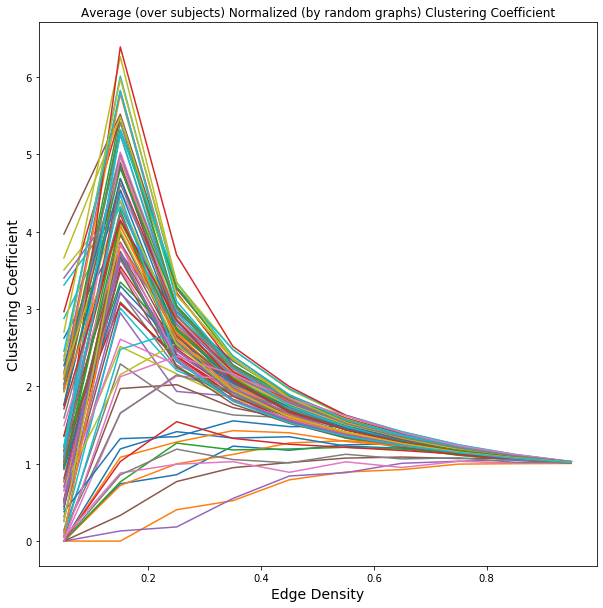

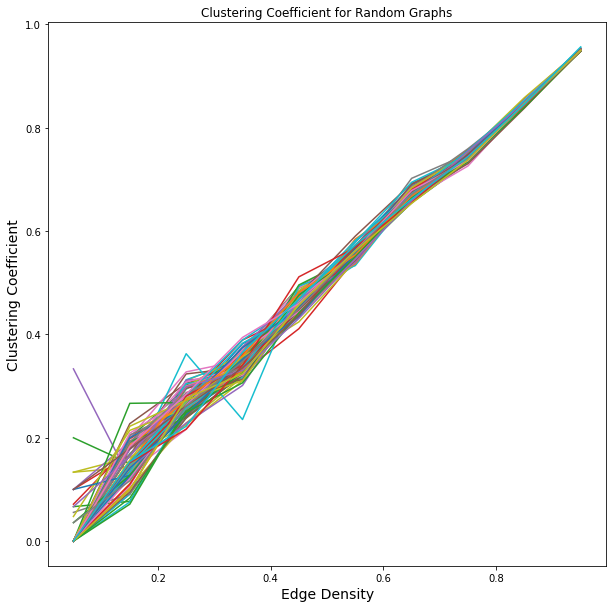

In [28]:
# This block plots the NORMALIZED clustering coefficient averaged over subjects versus edge density
# As before Each (color) line corresponds to one of the 90 nodes in the graph
plt.rcParams["figure.figsize"] = (10,10)
for node in range(0,90):
    plt.plot(rho, c_average[:,node], label=str(node))
plt.xlabel("Edge Density",fontsize=14)
plt.ylabel("Clustering Coefficient",fontsize=14)
plt.title("Average (over subjects) Normalized (by random graphs) Clustering Coefficient")
plt.show()

# This block plots the clustering coefficient versus edge density for a random graph
# Each (color) line corresponds to one of the 90 nodes in the graph
sub = 1
for node in range(0,90):
    plt.plot(rho, c_rand[sub,:,node], label=str(node))
plt.xlabel("Edge Density",fontsize=14)
plt.ylabel("Clustering Coefficient",fontsize=14)
plt.title("Clustering Coefficient for Random Graphs")
plt.show()

We will now observe what happens when nodes of the network are shut down in sequence. We will investigate two cases: 
 * one in which nodes are shut down in a random order (by setting the associated row/column of the connectivity matrix to null vectors), and 
 * one in which nodes are shut down starting with the ones exhibiting the larger degree. 
 
For an edge density of $0.3$, we will compute the average nodal clustering coefficient across nodes for each subject, incrementally removing a node at a time. 

Run the next cell to display the resulting curves, and compare both the random and specific shutting down cases.

In [29]:
# This cell performs node removal for each subject's adjacency matrix and at each step calculates
# the average (over nodes) clustering coefficient. This is repeated twice, for random node removal, and
# for removal of the node with the highest degree

rho = 0.3
c_rem = np.zeros((54,89))
c_rem_targ = np.zeros((54,89))
for sub in range(0,54):
    adj = BinarizeAdjacency(np.squeeze(ComputeAdjacency(TCS[sub,:,:])),rho).astype(int)
    adj_targ = adj
    for counter in range (1,90):
        node = np.random.randint(0, adj.shape[0])
        adj = np.delete(adj, node, 0)
        adj = np.delete(adj, node, 1)
        c_rem[sub, counter-1] = np.mean(ComputeC(adj))
        
        deg = adj_targ.dot(np.ones(adj_targ.shape[0],))
        node = np.argmax(deg)
        adj_targ = np.delete(adj_targ, node, 0)
        adj_targ = np.delete(adj_targ, node, 1)
        c_rem_targ[sub, counter-1] = np.mean(ComputeC(adj_targ))
        

Now run the next cell to plot the node-averaged clustering coefficient versus number of nodes removed. 

<div class = 'alert alert-info'>
    
**Note:** Each subject's graph corresponds to two lines: one *blue-ish* for random node removal, and one *red-ish* for highest degree node removal.
</div>

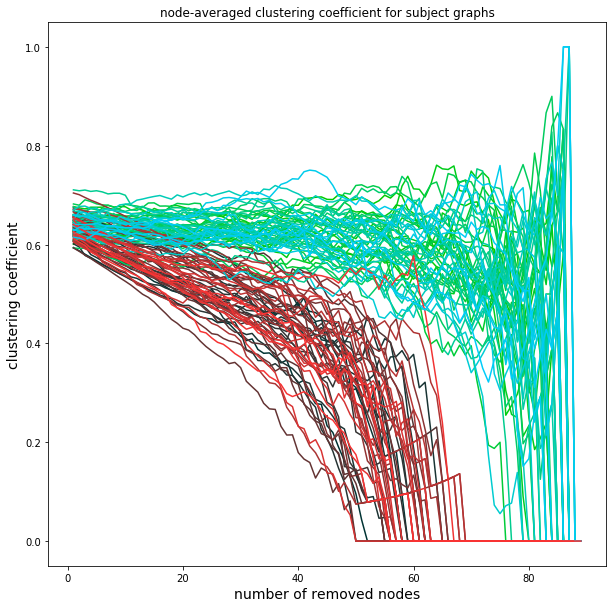

In [30]:
plt.figure()
for sub in range(0,54):
    plt.plot(np.arange(1,90), c_rem[sub,:], color=[0,0.8,sub/54])
    plt.plot(np.arange(1,90), c_rem_targ[sub,:], color=[sub/54,0.2,0.2])
plt.xlabel("number of removed nodes",fontsize=14)
plt.ylabel("clustering coefficient",fontsize=14)
plt.title("node-averaged clustering coefficient for subject graphs")
plt.show()

#### Reflection point:

Cold colors refer to the random node removal case, while warm colors denote targeted node removal, starting with the node with largest degree. We notice a gradual decrease of the clustering coefficient in all subject cases, which is logical as we gradually remove edges from the graph by excluding nodes. 

More importantly, we see that the targeted removal curves reach zero faster, which means that local information flow as quantified by the clustering coefficient suffers more from the exclusion of high-degree nodes from the network. 

This highlights the fact that there is a subset of brain regions that are particularly important to maintain correct brain functional architecture, because they are hubs that particularly strongly contribute to both local information flow, and long-distance interactions (for this reason, we would actually expect the same type of outcome if quantifying path length).

# 3. Gender Classification

We will now attempt to use a linear Support Vector Machine (*SVM*) framework in order to classify male and female subjects from our dataset according to their brain connectivity feature. This is a task that has already been undertaken by previous research work [see original paper](https://www.sciencedirect.com/science/article/pii/S105381191001058X). 

For this purpose, we resort to a leave-one-out cross-validation (*LOOCV*) framework with labels $0$ and $1$ for male and female subjects, respectively. In the present data, the first 27 subjects are male, and the second half of subjects are female.

Look back at your [course notes](https://moodle.epfl.ch/pluginfile.php/1674937/mod_resource/content/8/7-ML.pdf) if you need to, and remember the principles of *LOOCV* and the reasons why it has to be used in this case. Also, briefly summarize the working principle of the linear SVM classification approach.

As a first trial, we will attempt to classify our subjects on the basis of nodal clustering coefficient data: each data point is thus a 90-dimensional feature vector. For density values ranging from 0.05 to 0.95 by increments of 0.1, we compute the training and testing *LOOCV* errors, and plot the two output curves. We will use the function `train_svm` we declared at the beginning of the notebook.

Run the next cell to clasify our subjects and plot the two error curves with respect to the edge density.

In [31]:
# train_svm() useful function for gender classification using SVM (remember the theory from the lecture)

def train_svm(X,labels):
    Err_test=0.
    Err_train_vec=np.zeros((X.shape[0],))
    for i in range(0,X.shape[0]):
        #split data into training and testing set (one sample)
        data_train=np.delete(X, i, 0)
        data_test=X[i,:].reshape(1, -1)
        C_train=np.delete(labels, i, 0).ravel()
        C_test=labels[i,:].reshape(1, -1)
        #train and predict
        model_svm_lin = LinearSVC(max_iter=5000)
        model_svm_lin.fit(data_train, C_train)
        C_pred_lin_test = model_svm_lin.predict(data_test)
        C_pred_lin_train = model_svm_lin.predict(data_train)
        Err_train_vec[i,] = np.sum(np.abs(C_pred_lin_train-C_train))*100/X.shape[0]
        if C_pred_lin_test!=C_test:
            Err_test += 1.
    
    Err_test=100*Err_test/X.shape[0]
    Err_train=np.mean(Err_train_vec)
    return Err_test, Err_train

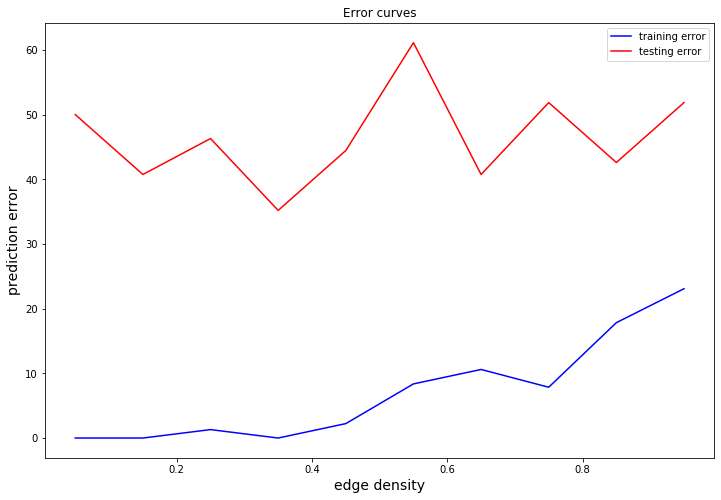

In [34]:
# This section performs LOOCV gender classification using linear SVM and clustering coefficient as features
etrain, etest = np.zeros((10,1)), np.zeros((10,1))
for rho_ind in range(0,10):
    X = np.squeeze(c[:, rho_ind, :])
    labels = np.zeros((X.shape[0],1))
    labels[27:,0] = 1
    
    #Perform linear SVM classification and store the test and training LOOCV errors for each rho_ind in etrain and etest
    # etest, etrain = train_svm()
    
    ### BEGIN SOLUTION
    etest[rho_ind,0], etrain[rho_ind,0] = train_svm(X,labels)
    ### END SOLUTION
    
plt.figure()
plt.plot(rho_vec, etrain,'b', label="training error")
plt.plot(rho_vec, etest,'r', label="testing error")
plt.legend()
plt.xlabel("edge density",fontsize=14)
plt.ylabel("prediction error",fontsize=14)
plt.title('Error curves')
plt.show()

Now, we want to instead use functional connectivity values themselves for classification purposes. We extract them from the subject-wise connectivity matrices, and compute training and testing errors in this case. 

Run the next cell to perform this classification and see the results.

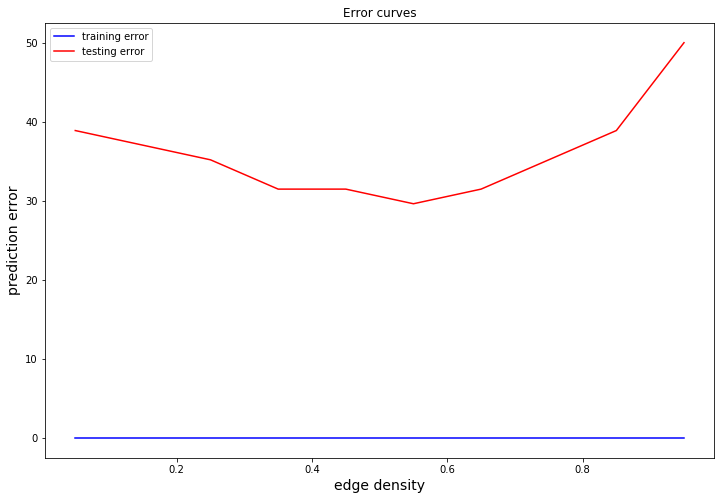

In [35]:
#This section performs LOOCV classification into male and female subjects
#using linear SVM and vectorized functional connectivity matrices as features
etrain, etest = np.zeros((10,1)), np.zeros((10,1))
for rho_ind in range(0,10):
    #build data matrix from functional connectivity
    X=np.zeros((54,90*90))
    for sub in range(0,54):
        adj = BinarizeAdjacency(np.squeeze(ComputeAdjacency(TCS[sub,:,:])),rho_vec[rho_ind,0])
        X[sub,:]=adj.reshape(1,-1)
    labels=np.zeros((X.shape[0],1))
    labels[27:,0]=1

    #Perform linear SVM classification and store the test and training LOOCV errors for each rho_ind in etrain and etest
    # etest, etrain = train_svm()
    
    ### BEGIN SOLUTION
    etest[rho_ind,0], etrain[rho_ind,0] = train_svm(X,labels)
    ### END SOLUTION

#This section plots the two error curves with respect to the edge density
plt.figure()
plt.plot(rho_vec, etrain,'b', label="training error")
plt.plot(rho_vec, etest,'r', label="testing error")
plt.legend()
plt.xlabel("edge density",fontsize=14)
plt.ylabel("prediction error",fontsize=14)
plt.title('Error curves')
plt.show()

### NOTE:

We should have applied a feature selection step before SVM training in order to reduce the risk of overfitting. The 0% error in the training set is due to clear overfitting.

# (bonus) 5. Connectomes in comparison

Now, let's go back to our **brain data**. Let's build a graph from the functional connectivity matrix 

In [89]:
# If you recall the very first weeks, from dMRI it's possible to have a tractography and a structural connectome
# Load the structural connectome and generate a structural graph from it using networkx. 

SC = scipy.io.loadmat("./FC_graphs_data/sub1_SC.mat")
SC = SC['sub1_SC']

# Binarize the matrix
SC_bin = np.copy(SC)
SC_bin[SC>=250] = 1
SC_bin[SC<250] = 0

G_str = nx.from_numpy_array(SC_bin)

In [84]:
## Create the functional graph in the same way but inputting as adjacency matrix the functional connectivity defined in section 1 of subject 1.

### BEGIN SOLUTION
G_fun = nx.from_numpy_array(Bin10)
### END SOLUTION
#G_fun = ...


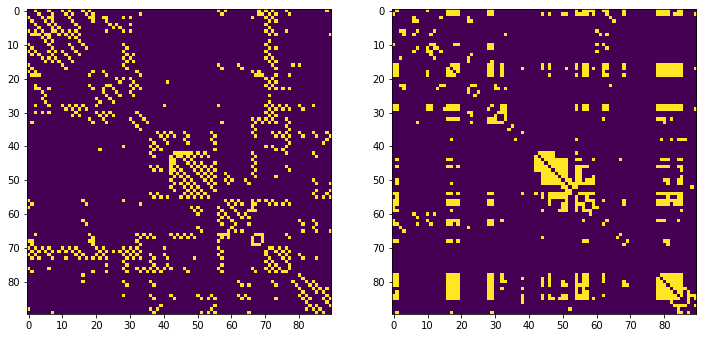

In [90]:
# Plot and visualize both Connectomes

plt.figure()
plt.subplot(121)
plt.imshow(SC_bin)
plt.subplot(122)
plt.imshow(Bin10)

What can you say about the two matrices already? Visually inspect the two and consider the connections. You can also normalize the values to put the 2 matrices on the same scale. Use also a colorbar.

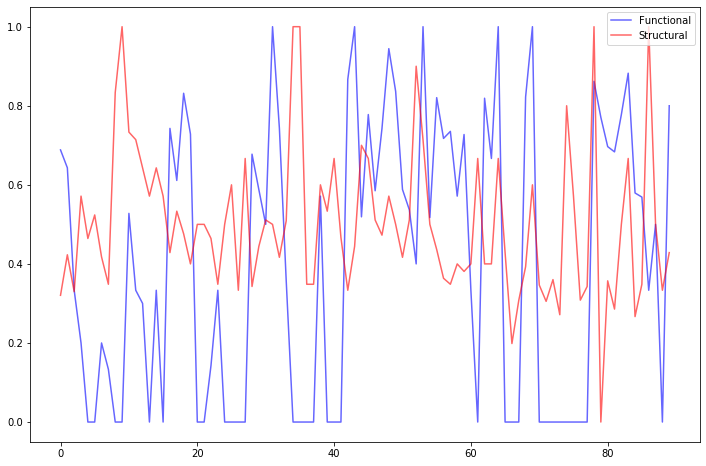

In [98]:
# Compare the two connectomes with a graph metric (e.g. local clustering coefficients)
# this time it's different from the global clustering coefficient seen before

loc_cc_fun = list(nx.clustering(G_fun).values())
loc_cc_str = list(nx.clustering(G_str).values())

# plot the two vectors with respect to the nodes

plt.figure()
plt.plot(loc_cc_fun, 'b', alpha=0.6)
plt.plot(loc_cc_str, 'r', alpha=0.6)

plt.legend({'Functional', 'Structural'})

Interpret these results: what can you say about each node?


You can also extend this reasoning to any other graph metric. Try it to belive! ;-)